## Exploring Streamflow data

This notebook allows the user to obtain different statistics from the daily streamflow data located in the data folder. The input csv should have the following structure

| Fecha         | Q      |
| :------       | :--    |
| dd/MM/YYYY    | 30.2   |

#### Import libraries

In [7]:
# Importing the libraries
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import os

from IPython.display import HTML

import warnings
warnings.filterwarnings('ignore')

##### Define user variables

In [8]:
# csv filename
station_name = '1330'
# Basin area
area_km2 = 8374
# Percentage of missing data
max_pct_missing = 50

In [9]:
# CSV folder
CSV_FOLDER = '..\stations\data'
CSV_FILE = os.path.join(CSV_FOLDER,station_name + '.csv')
print(CSV_FILE)

..\stations\data\1330.csv


In [10]:
# Read file
DISCHARGE_DAILY = pd.read_csv(CSV_FILE,parse_dates=['Fecha'],index_col="Fecha",dayfirst=True,na_values="NA")
# Identify the missing data
DISCHARGE_DAILY_date_missing = pd.date_range(start = DISCHARGE_DAILY.index[0].strftime('%Y-%m-%d'), end = DISCHARGE_DAILY.index[-1].strftime('%Y-%m-%d'),freq='D')
DISCHARGE_DAILY = DISCHARGE_DAILY.reindex(DISCHARGE_DAILY_date_missing,fill_value=None)
DISCHARGE_DAILY.index.name = 'Fecha' # Set index Fecha
DISCHARGE_DAILY.columns = ['Discharge']
## create column for day, month, year in the daily discharge ()
DISCHARGE_DAILY['year'] = DISCHARGE_DAILY.index.year
DISCHARGE_DAILY['month'] = DISCHARGE_DAILY.index.month
DISCHARGE_DAILY['monthday'] = DISCHARGE_DAILY.index.day_of_year
HTML(DISCHARGE_DAILY.tail(6).to_html())

,Discharge,year,month,monthday
Fecha,,,,
2025-12-26,2.043,2025,12,360
2025-12-27,2.005,2025,12,361
2025-12-28,2.016,2025,12,362
2025-12-29,1.999,2025,12,363
2025-12-30,2.029,2025,12,364
2025-12-31,1.951,2025,12,365


##### Plot hydrograph

In [11]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=DISCHARGE_DAILY.index,    
    y=DISCHARGE_DAILY['Discharge'], 
    mode='lines+markers',               
    name='Streamflow (m3/s)'
))

fig.update_layout(
    title=f'Hydrograph',
    xaxis_title='Date',
    yaxis_title='Discharge (m³/s)'
)

fig.show()

##### Duration Curve

In [12]:
DATA_DAILY = DISCHARGE_DAILY.dropna(subset=['Discharge'])
sorted_stage= DATA_DAILY['Discharge'].sort_values(ascending=False)
freq_stage = np.arange(1., len(sorted_stage) + 1) / len(sorted_stage)

df_freq = sorted_stage.to_frame(name='stage')
df_freq['frequency'] = freq_stage

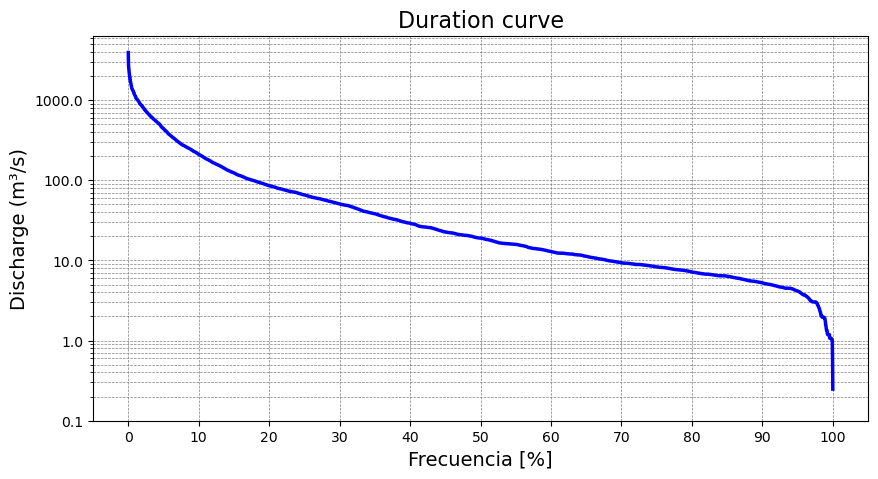

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
# Create the matplotlib plot with adjusted figure size
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(freq_stage * 100, sorted_stage, color='blue', linewidth=2.5)

ax.set_title('Duration curve', fontsize=16)
ax.set_xlabel('Frecuencia [%]', fontsize=14)
ax.set_ylabel('Discharge (m³/s)', fontsize=14)

# Set y-axis to log scale
ax.set_yscale('log')

# Set x and y-axis ticks and format
ax.set_xticks(np.arange(0, 101, 10))
ax.set_yticks([0.1, 1, 10, 100, 1000])
ax.get_yaxis().set_major_formatter(ScalarFormatter())

# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

##### Convert to monthly

In [14]:
# from daily to monthly
DISCHARGE_MONTHLY = DISCHARGE_DAILY.resample('M',closed="right").apply(lambda x: x.mean() if x.isnull().sum()*100/len(x) < max_pct_missing else np.nan)
# from monthly to 3 months
DISCHARGE_THREE_MONTHS = DISCHARGE_MONTHLY.rolling(3).apply(lambda x: x.mean() if x.isnull().sum()*100/len(x) < max_pct_missing else np.nan)
# Create columns
DISCHARGE_MONTHLY['year'] = DISCHARGE_MONTHLY.index.year
DISCHARGE_MONTHLY['month'] = DISCHARGE_MONTHLY.index.month
DISCHARGE_MONTHLY['water_year'] = DISCHARGE_MONTHLY.index.year.where(DISCHARGE_MONTHLY.index.month >= 4, DISCHARGE_MONTHLY.index.year - 1)
## create column for day, month, year in the daily discharge ()
DISCHARGE_DAILY['year'] = DISCHARGE_DAILY.index.year
DISCHARGE_DAILY['month'] = DISCHARGE_DAILY.index.month
DISCHARGE_DAILY['day'] = DISCHARGE_DAILY.index.day
DISCHARGE_DAILY['monthday'] = DISCHARGE_DAILY.index.day_of_year
# The water year for this region starts in April (4)
DISCHARGE_DAILY['water_year'] = DISCHARGE_DAILY.index.year.where(DISCHARGE_DAILY.index.month >= 4, DISCHARGE_DAILY.index.year - 1)
# Change the day in the datetime column
DISCHARGE_MONTHLY.index = DISCHARGE_MONTHLY.index.map(lambda t: t.replace(day=1))
## print the first results
HTML(DISCHARGE_MONTHLY.tail(6).to_html(index=True))
# DISCHARGE_MONTHLY.to_clipboard() # Uncomment if you want to visualize all the time serie

,Discharge,year,month,monthday,water_year
Fecha,,,,,
2025-07-01,11.830516,2025,7,197.0,2025
2025-08-01,30.211484,2025,8,228.0,2025
2025-09-01,13.166900,2025,9,258.5,2025
2025-10-01,15.270839,2025,10,289.0,2025
2025-11-01,3.939100,2025,11,319.5,2025
2025-12-01,1.634710,2025,12,350.0,2025


#### Convert to daily volumen in m3 and hm3

In [15]:
# Convert daily discharge (m³/s) to daily volume (hm³)
seconds_in_a_day = 86400
DISCHARGE_DAILY['Daily_Volume_m3'] = DISCHARGE_DAILY['Discharge'] * seconds_in_a_day
DISCHARGE_DAILY['Daily_Volume_hm3'] = DISCHARGE_DAILY['Daily_Volume_m3'] / 1e6
HTML(DISCHARGE_DAILY.tail(6).to_html(index=True))

,Discharge,year,month,monthday,day,water_year,Daily_Volume_m3,Daily_Volume_hm3
Fecha,,,,,,,,
2025-12-26,2.043,2025,12,360,26,2025,176515.2,0.176515
2025-12-27,2.005,2025,12,361,27,2025,173232.0,0.173232
2025-12-28,2.016,2025,12,362,28,2025,174182.4,0.174182
2025-12-29,1.999,2025,12,363,29,2025,172713.6,0.172714
2025-12-30,2.029,2025,12,364,30,2025,175305.6,0.175306
2025-12-31,1.951,2025,12,365,31,2025,168566.4,0.168566


In [16]:
# Calculate the day of the water year (1 to 365/366)
def get_water_year_day(date):
    start_of_water_year = pd.Timestamp(year=date.year, month=4, day=1)
    if date.month < 4:
        start_of_water_year = pd.Timestamp(year=date.year - 1, month=4, day=1)
    
    return (date - start_of_water_year).days + 1

DISCHARGE_DAILY['day_of_water_year'] = DISCHARGE_DAILY.index.map(get_water_year_day)
HTML(DISCHARGE_DAILY.tail(6).to_html(index=True))

,Discharge,year,month,monthday,day,water_year,Daily_Volume_m3,Daily_Volume_hm3,day_of_water_year
Fecha,,,,,,,,,
2025-12-26,2.043,2025,12,360,26,2025,176515.2,0.176515,270
2025-12-27,2.005,2025,12,361,27,2025,173232.0,0.173232,271
2025-12-28,2.016,2025,12,362,28,2025,174182.4,0.174182,272
2025-12-29,1.999,2025,12,363,29,2025,172713.6,0.172714,273
2025-12-30,2.029,2025,12,364,30,2025,175305.6,0.175306,274
2025-12-31,1.951,2025,12,365,31,2025,168566.4,0.168566,275


#### Annual and Monthly Scale

In [17]:
DISCHARGE_SELECTION = DISCHARGE_MONTHLY[(DISCHARGE_MONTHLY['year'] >= 1980) & (DISCHARGE_MONTHLY['year'] <= 2010)]
DISCHARGE_AVERAGE = DISCHARGE_SELECTION.groupby(DISCHARGE_SELECTION.month).mean()
DISCHARGE_AVERAGE = DISCHARGE_AVERAGE.reindex(columns=['Discharge'])
HTML(DISCHARGE_AVERAGE.round(decimals=2).transpose().to_html())

month,1,2,3,4,5,6,7,8,9,10,11,12
Discharge,28.3,66.02,59.1,89.24,116.94,150.5,148.88,126.41,133.2,114.03,92.93,41.55


In [18]:
q = (DISCHARGE_SELECTION['Discharge'].mean() * 1000) / area_km2
v = (DISCHARGE_SELECTION['Discharge'].mean() * 31557600) / 1000000 # Convert from m3/s to hm3/year

print(f"El caudal promedio anual es (1980-2010): {DISCHARGE_SELECTION['Discharge'].mean():.2f} m³/s")
print(f"El caudal especifico es (1980-2010): {q:.2f} l/s/km²")
print(f"El volumen anual promedio es (1980-2010): {v:.2f} hm³")

El caudal promedio anual es (1980-2010): 97.55 m³/s
El caudal especifico es (1980-2010): 11.65 l/s/km²
El volumen anual promedio es (1980-2010): 3078.39 hm³


In [19]:
import plotly.express as px

# Agregar columna con abreviaturas de mes en español
meses = ['ENE', 'FEB', 'MAR', 'ABR', 'MAY', 'JUN',
         'JUL', 'AGO', 'SEP', 'OCT', 'NOV', 'DIC']
DISCHARGE_AVERAGE = DISCHARGE_AVERAGE.copy()
DISCHARGE_AVERAGE['Mes'] = [meses[m-1] for m in DISCHARGE_AVERAGE.index]

# Crear gráfico de barras
fig = px.bar(DISCHARGE_AVERAGE,
             x='Mes',
             y='Discharge',
             labels={'Discharge': 'Discharge (m³/s)', 'Mes': 'Month'},
             title='Monthly Discharge')

fig.update_layout(
    xaxis_tickfont=dict(size=14),
    yaxis_tickfont=dict(size=14),
    title_font=dict(size=20)
)

fig.show()

##### Monthly period

In [20]:
# Define the monthly periods
monthly_periods = {
    1: 'Ene', 2: 'Feb', 3: 'Mar', 4: 'Abr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dic'
}

results = {}

for month_num, month_label in monthly_periods.items():
    # Filter the monthly data for the current month
    monthly_data = DISCHARGE_SELECTION[DISCHARGE_SELECTION['month'] == month_num]
    
    # Calculate the mean discharge
    mean_discharge = monthly_data['Discharge'].mean()
    
    # Calculate q and Q80
    q = (mean_discharge * 1000) / area_km2
    Q80 = np.nanpercentile(monthly_data['Discharge'], 20)
    Q20 = np.nanpercentile(monthly_data['Discharge'], 80)
    Q90 = np.nanpercentile(monthly_data['Discharge'], 10)
    Q10 = np.nanpercentile(monthly_data['Discharge'], 90)
    Q60 = np.nanpercentile(monthly_data['Discharge'], 40)
    Q40 = np.nanpercentile(monthly_data['Discharge'], 60)

    Qmax = np.nanmax(monthly_data['Discharge'])
    Qmin = np.nanmin(monthly_data['Discharge'])

    # Specific discharge
    q80 = (Q80*1000)/area_km2
    q20 = (Q20*1000)/area_km2
    qmax = (Qmax*1000)/area_km2
    qmin = (Qmin*1000)/area_km2
    
    # Calculate the average monthly volume
    seconds_in_a_year = 31557600
    seconds_in_a_month_avg = seconds_in_a_year / 12
    v_month = (mean_discharge * seconds_in_a_month_avg) / 1e6

    results[month_label] = {'mean_discharge (m³/s)': mean_discharge, 
                            'q (l/s/km²)': q, 
                            'Vol (hm³)': v_month, 
                            'Q80 (m³/s)': Q80, 
                            'q80 (l/s/km²)':q80,
                            'Q20 (m³/s)':Q20,
                            'q20 (l/s/km²)':q20,
                            'qmax (l/s/km²)':qmax,
                            'qmin (l/s/km²)':qmin}

# Print the results in a clear format
for month, values in results.items():
    print(f"--- Resultados para {month} ---")
    print(f"El caudal promedio (1980-2010): {values['mean_discharge (m³/s)']:.2f} m³/s")
    print(f"El caudal especifico (1980-2010): {values['q (l/s/km²)']:.2f} l/s/km²")
    print(f"El volumen mensual promedio (1980-2010): {values['Vol (hm³)']:.2f} hm³")
    print(f"El 180 (Caudal frecuencia 80% del tiempo) es (1980-2010): {values['Q80 (m³/s)']:.2f} m³/s ({(values['Q80 (m³/s)']*1000)/area_km2:.1f} l/s/km²)")
    print()

--- Resultados para Ene ---
El caudal promedio (1980-2010): 28.30 m³/s
El caudal especifico (1980-2010): 3.38 l/s/km²
El volumen mensual promedio (1980-2010): 74.42 hm³
El 180 (Caudal frecuencia 80% del tiempo) es (1980-2010): 5.60 m³/s (0.7 l/s/km²)

--- Resultados para Feb ---
El caudal promedio (1980-2010): 66.02 m³/s
El caudal especifico (1980-2010): 7.88 l/s/km²
El volumen mensual promedio (1980-2010): 173.61 hm³
El 180 (Caudal frecuencia 80% del tiempo) es (1980-2010): 7.07 m³/s (0.8 l/s/km²)

--- Resultados para Mar ---
El caudal promedio (1980-2010): 59.10 m³/s
El caudal especifico (1980-2010): 7.06 l/s/km²
El volumen mensual promedio (1980-2010): 155.43 hm³
El 180 (Caudal frecuencia 80% del tiempo) es (1980-2010): 8.96 m³/s (1.1 l/s/km²)

--- Resultados para Abr ---
El caudal promedio (1980-2010): 89.24 m³/s
El caudal especifico (1980-2010): 10.66 l/s/km²
El volumen mensual promedio (1980-2010): 234.68 hm³
El 180 (Caudal frecuencia 80% del tiempo) es (1980-2010): 11.21 m³/s (1

In [21]:
# Create the DataFrame from the results dictionary
df_results = pd.DataFrame(results).round(decimals=1)
# Define the new desired order of months
new_order = ['Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic', 'Ene', 'Feb', 'Mar']
# Reorder the DataFrame columns
df_results = df_results[new_order]
df_results

,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic,Ene,Feb,Mar
mean_discharge (m³/s),89.2,116.9,150.5,148.9,126.4,133.2,114.0,92.9,41.6,28.3,66.0,59.1
q (l/s/km²),10.7,14.0,18.0,17.8,15.1,15.9,13.6,11.1,5.0,3.4,7.9,7.1
Vol (hm³),234.7,307.5,395.8,391.5,332.4,350.3,299.9,244.4,109.3,74.4,173.6,155.4
Q80 (m³/s),11.2,15.0,39.8,65.7,38.1,34.3,22.4,15.7,8.5,5.6,7.1,9.0
q80 (l/s/km²),1.3,1.8,4.7,7.8,4.6,4.1,2.7,1.9,1.0,0.7,0.8,1.1
Q20 (m³/s),123.4,190.1,236.6,197.9,185.1,192.9,202.1,179.0,49.8,36.3,39.6,90.9
q20 (l/s/km²),14.7,22.7,28.3,23.6,22.1,23.0,24.1,21.4,6.0,4.3,4.7,10.8
qmax (l/s/km²),62.2,70.9,56.7,55.3,70.1,49.5,48.8,38.5,31.2,22.7,67.7,46.1
qmin (l/s/km²),0.9,0.6,0.8,1.7,0.9,2.5,0.7,0.8,0.8,0.2,0.5,0.7


In [22]:
# Using plotly to create a barplot of the last 12 month of monthly discharge data
import plotly.express as px
import datetime
# Get the last 12 months
last_date = DISCHARGE_MONTHLY.index.max()
start_date = last_date - pd.DateOffset(months=11)
DISCHARGE_LAST_12_MONTHS = DISCHARGE_MONTHLY[(DISCHARGE_MONTHLY.index >= start_date) & (DISCHARGE_MONTHLY.index <= last_date)]

meses_map = {1: 'Ene', 2: 'Feb', 3: 'Mar', 4: 'Abr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dic'}

# x values (same as bar x)
x = DISCHARGE_LAST_12_MONTHS.index.strftime('%m-%Y')
months_nums = DISCHARGE_LAST_12_MONTHS.index.month

# extract series from df_results using the month labels
y_mean = [df_results.loc['mean_discharge (m³/s)', meses_map[m]] for m in months_nums]
y_q20  = [df_results.loc['Q20 (m³/s)', meses_map[m]]            for m in months_nums]
y_q80  = [df_results.loc['Q80 (m³/s)', meses_map[m]]            for m in months_nums]

fig = px.bar(
    DISCHARGE_LAST_12_MONTHS,
    x=DISCHARGE_LAST_12_MONTHS.index.strftime('%m-%Y'),
    y='Discharge',
    labels={'x': 'Mes-Año', 'Discharge': 'Caudal (m³/s)'},
    title='Estado actual del caudal mensual - Últimos 12 meses',
    color_discrete_sequence=['rgb(0,0,66)']
)


# add traces to existing figure
fig.add_trace(go.Scatter(x=x, y=y_mean, mode='lines+markers',
                         name='Caudal Promedio Mensual (m³/s)',
                         marker=dict(symbol='circle', size=10),
                         line=dict(color='firebrick', width=2),
                         visible='legendonly',
                         showlegend=True))

fig.add_trace(go.Scatter(x=x, y=y_q20, mode='lines+markers',
                         name='Q20 (m³/s)',
                         marker=dict(symbol='diamond', size=10),
                         line=dict(color='green', width=2),
                         visible='legendonly',
                         showlegend=True))

fig.add_trace(go.Scatter(x=x, y=y_q80, mode='lines+markers',
                         name='Q80 (m³/s)',
                         marker=dict(symbol='x', size=10),
                         line=dict(color='royalblue', width=2),
                         showlegend=True))

# ensure bars are shown side-by-side (grouped) if multiple traces exist
fig.update_layout(barmode='group')
fig.update_layout(
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
    xaxis_tickfont=dict(size=14),
    yaxis_tickfont=dict(size=14),
    title_font=dict(size=20)
)
fig.show()

#### Four-month period analysis

In [23]:
# Define the periods
periods = {
    'q1': ([4, 5, 6, 7],"ABR-JUL"),
    'q2': ([8, 9, 10, 11],"AGO-NOV"),
    'q3': ([12, 1, 2, 3],"DIC-MAR")
}

results = {}

for period_name, (months, period_label) in periods.items():
    # Filter the monthly data for the current period
    DISCHARGE_q = DISCHARGE_SELECTION[DISCHARGE_SELECTION.index.month.isin(months)]

    # Calculate the mean discharge
    mean_discharge = DISCHARGE_q['Discharge'].mean()

    # Calculate q and q80
    q = (mean_discharge * 1000) / area_km2
    Q80 = np.nanpercentile(DISCHARGE_q['Discharge'], 20)
    Q60 = np.nanpercentile(DISCHARGE_q['Discharge'], 40)
    Q90 = np.nanpercentile(DISCHARGE_q['Discharge'], 10)

    # Calculate the average four-month volume
    seconds_in_a_year = 31557600
    seconds_in_four_months = seconds_in_a_year * (4/12)
    v_four_month = (mean_discharge * seconds_in_four_months) / 1e6

    results[period_name] = {'mean_discharge (m³/s)': mean_discharge, 
                            'q (l/s/km²)': q, 
                            'Vol (hm³)': v_four_month, 
                            'period_label': period_label, 
                            'Q80 (m³/s)': Q80}

# Print the results in the user's requested format
for period_name, values in results.items():
    print(f"--- Resultados para {values['period_label']} ---")
    print(f"El caudal promedio (1980-2010): {values['mean_discharge (m³/s)']:.1f} m³/s")
    print(f"El caudal especifico (1980-2010): {values['q (l/s/km²)']:.1f} l/s/km²")
    print(f"El volumen cuatrimestral promedio (1980-2010): {values['Vol (hm³)']:.1f} hm³")
    print(f"El q80 (Caudal frecuencia 80% del tiempo) es (1980-2010): {values['Q80 (m³/s)']:.2f} m³/s")
    print()

--- Resultados para ABR-JUL ---
El caudal promedio (1980-2010): 126.7 m³/s
El caudal especifico (1980-2010): 15.1 l/s/km²
El volumen cuatrimestral promedio (1980-2010): 1332.7 hm³
El q80 (Caudal frecuencia 80% del tiempo) es (1980-2010): 18.27 m³/s

--- Resultados para AGO-NOV ---
El caudal promedio (1980-2010): 116.9 m³/s
El caudal especifico (1980-2010): 14.0 l/s/km²
El volumen cuatrimestral promedio (1980-2010): 1229.3 hm³
El q80 (Caudal frecuencia 80% del tiempo) es (1980-2010): 25.82 m³/s

--- Resultados para DIC-MAR ---
El caudal promedio (1980-2010): 48.7 m³/s
El caudal especifico (1980-2010): 5.8 l/s/km²
El volumen cuatrimestral promedio (1980-2010): 512.1 hm³
El q80 (Caudal frecuencia 80% del tiempo) es (1980-2010): 7.39 m³/s



In [24]:
# Assuming 'results' is your dictionary variable
for period_name in results:
    results[period_name].pop('period_label', None)

# Create the DataFrame from the results dictionary
df_results_fourmonth = pd.DataFrame(results)

# Now apply rounding to the numerical values
df_results_fourmonth = df_results_fourmonth.round(decimals=1)

# Rename the columns for better readability
df_results_fourmonth.rename(columns={'q1': 'ABR-JUL', 'q2': 'AGO-NOV', 'q3': 'DIC-MAR'}, inplace=True)

# Display the final, corrected DataFrame
df_results_fourmonth

,ABR-JUL,AGO-NOV,DIC-MAR
mean_discharge (m³/s),126.7,116.9,48.7
q (l/s/km²),15.1,14.0,5.8
Vol (hm³),1332.7,1229.3,512.1
Q80 (m³/s),18.3,25.8,7.4


In [25]:
# Using plotly to create a barplot of the last 12 month of monthly discharge data
fig = px.bar(
    DISCHARGE_LAST_12_MONTHS,
    x=DISCHARGE_LAST_12_MONTHS.index.strftime('%m-%Y'),
    y='Discharge',
    labels={'x': 'Mes-Año', 'Discharge': 'Caudal (m³/s)'},
    title='Estado actual del caudal mensual - Últimos 12 meses',
    color_discrete_sequence=['rgb(0,0,66)']
)

# prepare x and month numbers
x = DISCHARGE_LAST_12_MONTHS.index.strftime('%m-%Y')
months_nums = DISCHARGE_LAST_12_MONTHS.index.month

# map month to four-month period column in df_results_fourmonth
def month_to_period(m):
    if m in (4,5,6,7):
        return 'ABR-JUL'
    if m in (8,9,10,11):
        return 'AGO-NOV'
    return 'DIC-MAR'

# build Q80 series from df_results_fourmonth for each month
y_q80_4m = [df_results_fourmonth.loc['Q80 (m³/s)', month_to_period(m)] for m in months_nums]

# add Q80 (from 4-month periods) as line + markers
fig.add_trace(go.Scatter(
    x=x,
    y=y_q80_4m,
    mode='lines+markers',
    name='Q80-cuatrimestre (m³/s)',
    marker=dict(symbol='diamond', size=8),
    line=dict(color='orange', width=2),
    showlegend=True
))

fig.update_layout(barmode='group',
                  legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1))
fig.show()